In [94]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

%matplotlib inline

image = Image.open("./aurora.jpg")
image_vector = np.asarray(image)

# Image Histogram Equalization

linear interpolation with hist

In [95]:
def hist_equalization(color_vector, number_bins = 256):
    origin_shape = color_vector.shape
    color_vector = color_vector.flatten()
    color_hist, bins = np.histogram(color_vector, number_bins, normed = True)
    cdf = color_hist.cumsum()
    cdf = 255 * cdf / cdf[-1]

    equalized = np.interp(color_vector.flatten(), bins[:-1], cdf)
    return equalized.reshape(origin_shape)

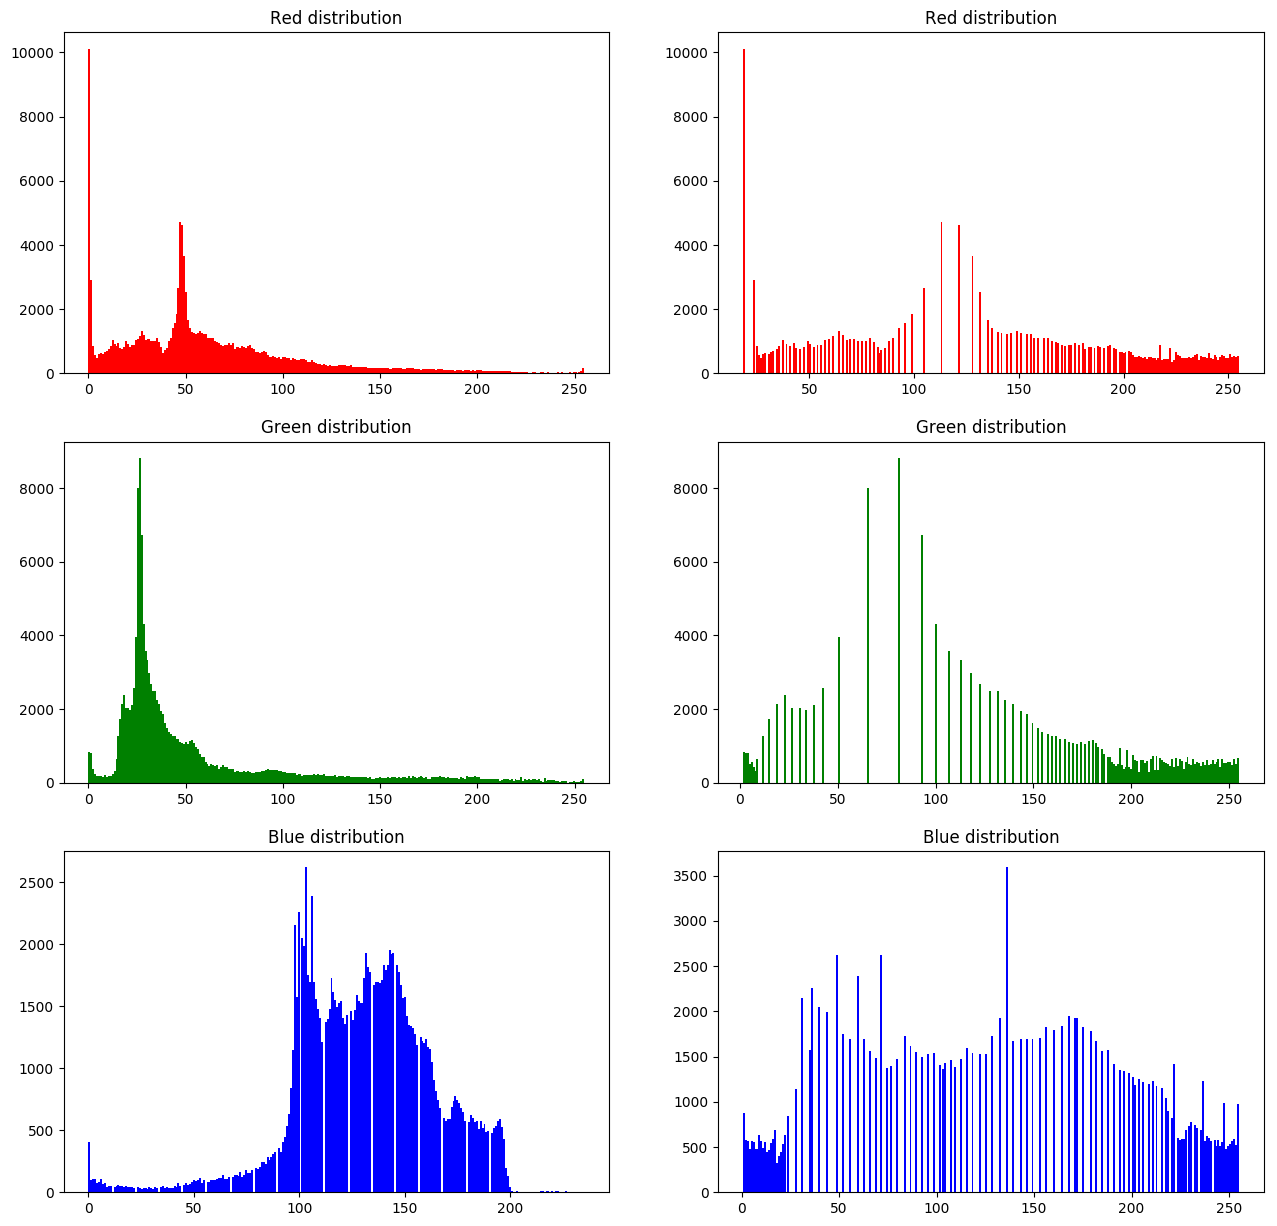

In [96]:
fig = plt.figure(dpi = 100)
plt.subplots_adjust(left=2, right=4, top=3, bottom=0.1)

colors = image_vector.shape[2]
titles = 'Red|Green|Blue'.split('|')
title_format = '{} distribution'

subplots = [fig.add_subplot(colors, 2, i + 1,
                            title = title_format.format(titles[int(i / 2)]))
            for i in range(colors * 2)]

height, width, _ = image_vector.shape

flatten_image_vector = image_vector.reshape((-1, 3)).copy()
flatten_heq_image_vector = np.zeros(flatten_image_vector.shape)

for i in range(colors):
    flatten_heq_image_vector[:, i] = hist_equalization(image_vector[:, :, i]).flatten()
    
fiv = flatten_image_vector.reshape((-1, 3, 1))
fhiv = flatten_heq_image_vector.reshape((-1, 3, 1))

hist_data = np.concatenate((fiv, fhiv), axis = 2)

for i in range(colors * 2):
    h, w = int(i / 2), i % 2
    _ = subplots[i].hist(hist_data[:, h, w], bins = 256, color = titles[int(i / 2)])
    
heq_image_vector = fhiv.reshape((height, width, 3))

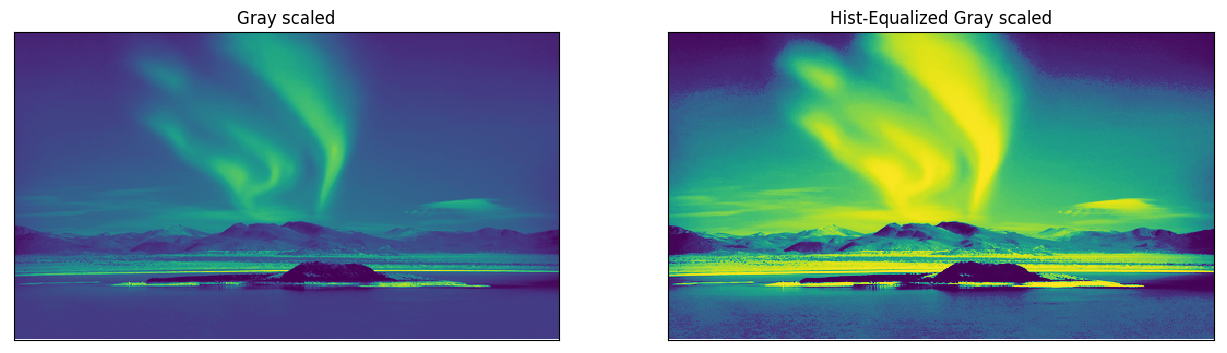

In [97]:
gray_image_vector = np.asarray(image.convert("L"))

he_image_vector = np.zeros(image_vector.shape)
he_image_vector = hist_equalization(gray_image_vector)

fig = plt.figure(dpi = 100)
plt.subplots_adjust(left=2, right=4, top=0.9, bottom=0.1)

left = fig.add_subplot(1, 2, 1, title = 'Gray scaled')
right = fig.add_subplot(1, 2, 2, title = 'Hist-Equalized Gray scaled')

left.get_xaxis().set_visible(False)
right.get_xaxis().set_visible(False)
left.get_yaxis().set_visible(False)
right.get_yaxis().set_visible(False)

_ = left.imshow(gray_image_vector)
_ = right.imshow(he_image_vector)

# Initial Centroids

초기 Centroid값 설정함.

현재는 Random으로 선택하여 실행하게 되어 있음

In [98]:
def pick_initial_centroids(image_vector, K):
    height, width, _ = image_vector.shape
    
    heights = np.random.choice(height, K)
    widths = np.random.choice(width, K)
    
    centroids = np.array([image_vector[t] for t in zip(heights, widths)])
    return centroids

In [99]:
def allocate_cluster(image_vector, centroids):
    allocated = np.zeros(image_vector.shape[:2])
    height, width, _ = image_vector.shape
    dist = np.zeros((height, width, len(centroids)))
    for idx, centroid in enumerate(centroids):
        dist[:, :, idx] = np.linalg.norm(image_vector - centroid, axis = 2)
    
    allocated = np.argmin(dist, axis = 2)
    return allocated

In [100]:
def recalc_centroids(image_vector, clusters, K):
    centroids = np.zeros((K, 3))
    for i in range(K):
        iv = image_vector[clusters == i]
        if len(iv) > 0:
            centroids[i] = np.mean(iv, axis = 0)
    return np.array(centroids)

In [101]:
def regress(image_vector, centroids):
    K = centroids.shape[0]
    new_clusters = allocate_cluster(image_vector, centroids)
    new_centroids = recalc_centroids(image_vector, new_clusters, K)
    return new_clusters, new_centroids

In [102]:
K = 32
height, width, _ = heq_image_vector.shape
clusters = np.zeros((height, width))
centroids = pick_initial_centroids(heq_image_vector, K)

while True:
    new_clusters, new_centroids = regress(heq_image_vector, centroids)
    if np.all(clusters == new_clusters):
        break
    clusters, centroids = new_clusters, new_centroids
    
new_image = np.zeros(image_vector.shape)
for i in range(K):
    new_image[clusters == i] = centroids[i]
        
new_image = new_image.astype('uint8')
Image.fromarray(new_image).save('./aurora-kmeans.jpg')

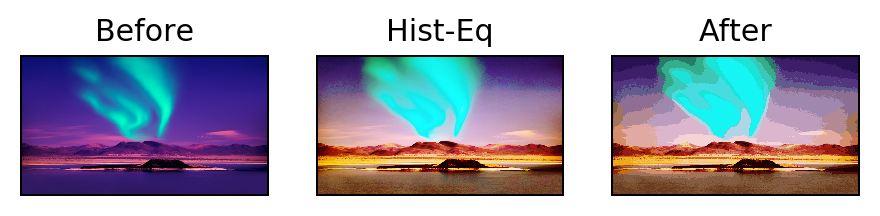

In [103]:
fig = plt.figure(dpi = 180)

ax1 = fig.add_subplot(1, 3, 1, title = 'Before')
ax2 = fig.add_subplot(1, 3, 2, title = 'Hist-Eq')
ax3 = fig.add_subplot(1, 3, 3, title = 'After')

ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

_ = ax1.imshow(image_vector), ax2.imshow(heq_image_vector.astype('uint8')), ax3.imshow(new_image)